### Calcualte shift values for all stars and explore the results

In [2]:
# imports
import astropy.io.fits 
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from astropy.utils.data import get_pkg_data_filename
import pandas as pd
import datetime 
import os
from astroquery.simbad import Simbad

In [29]:

# define constants and APF wavelenght scale (only used to determine order boundaries)
apf_wave = astropy.io.fits.open('apf_wav.fits')
c = 2.99 * 10**8 # m/s
#solar_ref = astropy.io.fits.open('./APF_spectra/HD10700/ND.fits')[0].data #  tau ceti
#solar_ref_wl = astropy.io.fits.open('./APF_spectra/HD10700/ND.fits')[1].data 


def calculate_shifts(star_name, path_unshifted, path_shifted, verbosity = 1, make_plots = False):
    hdu_U = astropy.io.fits.open(path_unshifted)
    hdu_S = astropy.io.fits.open(path_shifted)
    
    # define the flux an wavelenght values
    wl_unshifted = hdu_U[1].data
    wl_shifted = hdu_S[1].data
    unshifted = hdu_U[0].data
    shifted = hdu_S[0].data

    # create lists to hold shift values
    pix_shift_arr = []
    wl_shift_arr = []
    v_shift_arr = []
    max_xcorr_value_arr = []
    midpoints = []

    for order in np.arange(32,44):

        # find order boundaries
        apf_order = apf_wave[0].data[order]
        low_bound = apf_order[0]
        up_bound = apf_order[-1]

        # define data for this order
        idxs_order_shifted = (wl_shifted > low_bound) * (wl_shifted < up_bound) 
        idxs_order_unshifted = (wl_unshifted > low_bound) * (wl_unshifted < up_bound)
        #idxs_order_solar = (solar_ref_wl > low_bound) * (solar_ref_wl < up_bound)
        flux_U = unshifted[idxs_order_unshifted]
        flux_S = shifted[idxs_order_shifted]
        #flux_solar = solar_ref[idxs_order_solar]
        wl_U = wl_unshifted[idxs_order_unshifted]
        wl_S = wl_shifted[idxs_order_shifted]
        #wl_solar = solar_ref_wl[idxs_order_solar]

        # calculate cross-correlation and calculate shifts 
        # shift each section so median is zero (otherwise the zero padding in cross correlation causes an issue)
        flux_S_centered = flux_S - np.median(flux_S)
        flux_U_centered = flux_U - np.median(flux_U)
        xcorr = np.correlate(flux_S_centered, flux_U_centered, mode='full')
        max_xcorr = np.where(xcorr == np.max(xcorr))[0]
        max_xcorr_value = np.max(xcorr)
        pixel_shift = len(wl_S) - max_xcorr 
        approx_delta_wl = np.mean(wl_U[1:] - wl_U[:-1]) # approximate becuase varies across spectrum
        wl_shift = pixel_shift*approx_delta_wl # approximate becuase uses assumption of constant wl per pixel
        delta_v = c * wl_shift / np.mean(wl_U) / 1000 # km/s
        midpoints += [np.mean(wl_U)]
        
        if (make_plots and ((float(delta_v) < -79) * (float(delta_v) > - 81))) and order == 34:    
            # plot shifted and unshifted spectra for reference
            plt.figure(figsize = [12,8])
            plt.subplot(211)
            plt.plot(wl_U, flux_U, '.-', label = 'unshifted', ms = 1)
            plt.plot(wl_S, flux_S, '.-', label = 'shifted', ms = 1)
            #plt.plot(wl_solar, flux_solar, '.-', label = 'solar reference', ms = 1)
            plt.xlabel('Wavelength [A]')
            plt.ylabel('Intensity')
            plt.title(star_name + ' Order: ' + str(order))
            #plt.xlim([5260,5280])
            plt.legend()

            # plot cross-correlation results
            plt.subplot(212)
            pix_lags = np.hstack([np.flip(np.arange(0,len(wl_U),1)*(-1))[1:], np.array([0]), np.arange(0,len(wl_U),1)[:-1]])   
            v_lags = pix_lags * approx_delta_wl * c / np.mean(wl_U) / 1000 # approximation becuase assumes constant wl per pixel and uses avg wl value
            xlim_l = np.where(v_lags < -200)[0][-1]
            xlim_u = np.where(v_lags > 200)[0][0]
            plt.plot(v_lags[xlim_l:xlim_u], xcorr[xlim_l:xlim_u])
            plt.xlabel('Velocity shift [km/s]')
            plt.ylabel('Cross-correlation')

        if verbosity > 0:
            print('Order ' + str(order))
            print('    Shift in pixels: ' + str(pixel_shift[0]))
            print('    Shift in wl: ' + str(wl_shift[0]))
            print('    Shift in v: ' + str(delta_v[0]))

        pix_shift_arr += [pixel_shift]
        wl_shift_arr += [wl_shift]
        v_shift_arr += [delta_v]
        max_xcorr_value_arr += [max_xcorr_value]

    pix_shift_arr = np.array(pix_shift_arr)
    wl_shift_arr = np.array(wl_shift_arr)
    v_shift_arr = np.array(v_shift_arr)[:,0]
    max_xcorr_value_arr = np.array(max_xcorr_value_arr)
    
    # interpolate to get a wavelenght shift value for each pixel
    #full_wl_shift_arr = np.interp(wl_shifted, midpoints, wl_shift_arr.reshape(len(wl_shift_arr),)) # this doesn't work wll near the ends
    
    # Find the median shift value
    med_v_shift = np.median(v_shift_arr)
    make_shift_plots = True
    if make_shift_plots * ((float(delta_v) < -79) * (float(delta_v) > - 81)):
        plt.figure()
        plt.plot(np.linspace(0,len(v_shift_arr)-1, len(v_shift_arr)), v_shift_arr, '.-')
        plt.xlabel('Order')
        plt.ylabel('Velocity shift value')
        #plt.text(2,4,'Median velocity shift value: ' + str(np.round(med_v_shift,3)))
        plt.title('Median velocity shift value: ' + str(np.round(med_v_shift,3)))
    if verbosity > 0:
        print('Median velocity shift value: ' + str(np.round(med_v_shift,3)))
        
    # get an array of wl shift values for each pixel
    wl_shift_full = wl_shifted * med_v_shift / c * 1000
        
    return wl_shift_arr, midpoints, wl_shifted, wl_shift_full, wl_unshifted, shifted, unshifted, med_v_shift, max_xcorr_value_arr

Timestamp: 06May2022-12:41:16
GJ1002: -19.280502546941126 km/s

HIP4845: 13.191922795218316 km/s

TIC158025009: 22.324792422623602 km/s

HIP64241: 8.118106335518963 km/s

HIP25878: -11.162396211349094 km/s

HIP96285: -58.85627093256795 km/s

HIP115445: 48.70863801315967 km/s

HIP109980: -11.162396211349094 km/s

HIP86032: -85.24011652294911 km/s

HIP80459: -3.0442898758254175 km/s

HIP76233: -21.31002913075736 km/s

HIP91430: -22.324792422698188 km/s

HIP103859: 1.0147632919442389 km/s

HIP70218: -12.177159503266942 km/s

HIP13601: 0.0 km/s

HIP19859: -11.162396211349094 km/s

HIP36393: -78.13677347944365 km/s

HIP56802: -14.206686087171573 km/s

HIP11000: 38.561005093751405 km/s

HIP86087: -10.147632919418058 km/s

HIP64394: -13.191922795230745 km/s

HIP36439: -1.0147632919432494 km/s

GJ144: 16.236212671053227 km/s

HIP9153: -16.743594317022414 km/s

HIP70400: -80.16630006317403 km/s

HIP4849: 35.516715217861915 km/s

HIP13642: 27.39860888240232 km/s

HIP26366: 127.86017478479148 km/

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP50384: 48.70863801315967 km/s

HIP28368: 26.38384559053732 km/s

HIP71284: -15.221449379068918 km/s

HIP65327: -8.118106335553868 km/s

HIP14669: 3.044289875828368 km/s

HIP82333: 23.339555714639012 km/s

HIP116416: -24.354319006626945 km/s

HIP105341: 50.738164596945595 km/s

HIP110951: -42.620058261555855 km/s

HIP92311: -0.5073816459682221 km/s

HIP87108: -80.16630006332531 km/s

GJ860A: -18.265739254952507 km/s

HIP5944: -6.088579751644959 km/s

HIP974: 19.280502546875702 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP77060: -80.16630006305748 km/s

HIP38228: 13.191922795186674 km/s

HIP20842: -8.6254879815007 km/s

TIC232540264: -76.10724689549028 km/s

HIP29277: -13.191922795193072 km/s

HIP50485: 6.088579751644959 km/s

HIP71311: -36.53147850980082 km/s

HIP65355: 49.723401305196674 km/s

HIP82587: -38.05362344778075 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP1473: -79.15153677153764 km/s

HIP10542: 16.23621267103006 km/s

HIP116584: -2.0295265838816534 km/s

HIP87558: -55.81198105669287 km/s

HIP92549: 9.13286962746744 km/s

HIP111169: -78.64415512537738 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP77070: -1.0147632919408267 km/s

HIP59496: -1.0147632919389116 km/s

GJ860B: -22.32479242261268 km/s

HIP97649: -81.1810633549552 km/s

HIP105668: -80.16630006301826 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP5110: -21.31002913075736 km/s

HIP20901: -30.442898758196115 km/s

HIP38325: 23.33955571465028 km/s

HIP71395: 12.177159503278444 km/s

HIP29650: 28.413372174248224 km/s

TIC233541860: -21.310029130757844 km/s

HIP83000: -65.45223233015123 km/s

HIP14862: -79.15153677149792 km/s

HIP65378: -77.12201018750281 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP77233: -78.13677347955705 km/s

HIP59514: -2.029526583879736 km/s

HIP92573: 7.10334304357565 km/s

HIP116613: -2.0295265838816534 km/s

HIP87585: -22.32479242267715 km/s

HIP111313: -8.118106335526614 km/s

GJ873: 19.28050254689431 km/s

HIP97650: -81.18106335526613 km/s

HIP105769: -20.802647484786704 km/s

HIP29761: 7.103343043599525 km/s

HIP51384: -59.36365257853909 km/s

TIC237222864: -5.073816459687182 km/s

HIP5957: -11.162396211349094 km/s

HIP21029: 53.78245447286381 km/s

HIP6537: 35.51671521792893 km/s

HIP15220: 13.191922795243476 km/s

HIP83451: -64.94485068421291 km/s

HIP38712: 46.17172978335246 km/s

HIP71743: -10.147632919398703 km/s

HIP87768: -36.53147850994042 km/s

HIP116758: -39.57576838569126 km/s

HIP77257: -59.87103422439579 km/s

HIP9269: -30.44289875828368 km/s

HIP112190: -11.162396211349094 km/s

HIP29800: 29.428135466283976 km/s

HIP105860: -35.00933357197537 km/s

GJ876: 10.147632919413166 km/s

HIP97675: 4.059053167763307 km/s

HIP59608: 11.162396211

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP92946: -104.01323742393546 km/s

HIP65477: -82.70320829313789 km/s

HIP87938: -28.413372174316372 km/s

HIP38956: 3.044289875813786 km/s

HIP71914: -12.177159503289918 km/s

HIP116771: 15.221449379083314 km/s

HIP83599: 65.45223233011949 km/s

HIP112245: -54.79721776480464 km/s

HIP77349: 14.206686087131 km/s

GJ905: -57.334125994767845 km/s

HIP105932: 84.22535323116989 km/s

HIP2: 32.472425342106455 km/s

HIP98036: -47.69387472121885 km/s

TIC255930614: -5.073816459713948 km/s

HIP15457: 4.059053167763307 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP59774: -72.04819372783248 km/s

HIP2120: -2.029526583877823 km/s

HIP72044: -13.191922795230745 km/s

HIP3909: -17.250975962961498 km/s

HIP92951: -81.18106335511294 km/s

HIP65515: 4.059053167763307 km/s

HIP88175: -70.5260487898872 km/s

HIP51502: -76.10724689556199 km/s

HIP116819: 19.280502546875702 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP83601: 14.2066860871513 km/s

HIP112496: -41.60529496969346 km/s

HIP100017: -2.0295265838797407 km/s

HIP7734: 8.118106335526614 km/s

HIP30060: -70.01866714391704 km/s

HIP98204: -3.044289875819611 km/s

HIP106231: 13.191922795262641 km/s

HIP15638: -20.802647484775413 km/s

TIC257870150: 41.097913323601766 km/s

HIP59816: 26.38384559047423 km/s

HIP3998: 24.354319006579836 km/s

HIP72220: -80.67368170929649 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP51819: 13.191922795230745 km/s

HIP100064: -3.0442898758224795 km/s

HIP21273: -18.265739254932434 km/s

HIP92984: 32.47242534207585 km/s

HIP88348: 15.2214493791124 km/s

HIP116838: -6.088579751644959 km/s

HIP65530: -17.25097596302742 km/s

HIP112527: -20.2952658387388 km/s

HIP77464: -74.585101957651 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP83608: -7.103343043606415 km/s

HIP30112: 59.87103422445222 km/s

HIP98677: 2.0295265838816534 km/s

HIP60303: 16.743594317021838 km/s

HIP15648: -43.12743990748635 km/s

HIP106400: 2.0295265838816534 km/s

TIC269701147: -11.162396211349094 km/s

HIP40035: 58.85627093237132 km/s

HIP100511: 28.413372174316372 km/s

HIP116936: 20.295265838816533 km/s

HIP72237: 58.85627093256795 km/s

HIP518: -27.39860888240232 km/s

HIP88601: 7.103343043585786 km/s

HIP65714: -12.177159503313472 km/s

HIP21421: 57.841507640627114 km/s

HIP112748: 14.206686087171573 km/s

HIP93101: -3.0442898758224795 km/s

HIP6069: -43.1274399075043 km/s

HIP30419: -81.68844500127548 km/s

HIP15673: -43.634821553455545 km/s

HIP7748: -22.324792422741364 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP83613: -79.65891841731676 km/s

HIP98698: -50.73816459704133 km/s

HIP106481: 26.38384559051253 km/s

HIP400: -8.118106335526614 km/s

TIC274942910: -40.59053167767223 km/s

HIP100859: -27.905990528372975 km/s

HIP116971: -105.02800071602574 km/s

HIP72607: 28.4133721743026 km/s

HIP88684: -13.191922795230745 km/s

HIP51933: 15.2214493791124 km/s

HIP60759: 24.354319006579836 km/s

HIP21482: 45.6643481373372 km/s

HIP15797: 12.177159503318991 km/s

HIP65859: 45.6643481373372 km/s

HIP112774: 6.088579751656736 km/s

HIP77516: -12.177159503289918 km/s

HIP93408: -37.03886015583845 km/s

HIP98767: -59.871034224508776 km/s

HIP40875: 7.1033430435926395 km/s

HIP83762: -27.39860888240232 km/s

HIP30630: 78.13677347933216 km/s

HIP10670: -83.71797158511795 km/s

HIP117197: 0.0 km/s

TIC287256467: 3.551671521789285 km/s

HIP101027: 11.162396211370682 km/s

HIP60866: -23.339555714639012 km/s

HIP72659: -16.23621267110038 km/s

HIP77622: -31.965043696119373 km/s

HIP52316: 60.8857975164496 k

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP41307: -41.0979133236047 km/s

HIP66077: 19.280502546820642 km/s

HIP93747: -63.422705746301915 km/s

HIP112870: -1.0147632919389116 km/s

HIP98792: -19.280502546875702 km/s

HIP117410: 20.295265838816533 km/s

HIP16499: -56.826744348579055 km/s

HIP21547: -73.57033866571017 km/s

HIP83988: 0.0 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP30756: 28.4133721743981 km/s

HIP60910: 23.846937360573733 km/s

HIP106811: 12.177159503289918 km/s

TIC298647682: -20.295265838816533 km/s

HIP101150: 10.147632919389117 km/s

HIP77655: -6.088579751644959 km/s

HIP72848: -7.103343043585786 km/s

HIP117463: -15.2214493791124 km/s

HIP4151: 21.31002913082902 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP52422: -80.16630006344167 km/s

HIP31592: 18.773120900894696 km/s

HIP88972: -12.177159503289918 km/s

HIP66252: -3.044289875813786 km/s

HIP21589: -80.16630006324976 km/s

HIP16846: -30.95028040419448 km/s

HIP93805: -55.811981056744486 km/s

HIP83996: 12.177159503289918 km/s

HIP98828: 15.2214493791124 km/s

HIP112909: -17.2509759630107 km/s

HIP106897: -70.01866714391704 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP60965: -80.16630006309637 km/s

TIC317548889: 9.13286962746744 km/s

HIP77660: 1.0147632919408267 km/s

HIP101180: 14.206686087158186 km/s

HIP72944: 21.310029130706827 km/s

HIP42080: 7.1033430436062 km/s

HIP31635: -28.4133721743981 km/s

HIP117559: -24.354319006579836 km/s

HIP52469: -80.16630006309637 km/s

HIP89087: -33.48718863404727 km/s

HIP66675: 58.85627093273709 km/s

HIP84012: -77.12201018753908 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP107346: 32.47242534209151 km/s

HIP16852: 58.85627093256795 km/s

HIP21594: 70.01866714391704 km/s

HIP9884: -39.57576838573043 km/s

HIP93843: -79.15153677138447 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP60994: -8.118106335534446 km/s

HIP77760: -43.634821553455545 km/s

HIP112915: 10.147632919398703 km/s

TIC317597583: 18.26573925493488 km/s

HIP73165: -79.15153677138447 km/s

HIP101262: -40.59053167771158 km/s

HIP31703: -78.13677347929621 km/s

HIP4288: 31.45766205016563 km/s

HIP11759: -49.7234013051005 km/s

HIP107350: -37.038860155839515 km/s

HIP21683: -91.3286962746744 km/s

HIP52470: -19.280502546875702 km/s

HIP89348: -34.50195192598811 km/s

HIP98906: 26.38384559039893 km/s

HIP66704: 5.073816459718895 km/s

HIP84123: 24.35431900664983 km/s

HIP1692: 17.250975963052063 km/s

HIP78180: -80.16630006317403 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP61053: -16.236212671037926 km/s

HIP112918: -11.162396211359912 km/s

HIP93871: 38.561005093751405 km/s

TIC328350926: 10.147632919369409 km/s

HIP101955: -58.85627093256795 km/s

HIP73457: 16.23621267106889 km/s

HIP428: -15.2214493791124 km/s

HIP3206: -79.15153677138447 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP21818: 29.428135466368545 km/s

HIP107556: -80.67368170925664 km/s

HIP117779: -1.0147632919408267 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP17027: 44.649584845396376 km/s

HIP5247: -5.073816459704133 km/s

HIP66781: 9.13286962746744 km/s

HIP89474: -57.841507640517975 km/s

HIP98921: -37.54624180181058 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP84183: -80.16630006332531 km/s

HIP112935: 38.56100509377003 km/s

HIP78241: -50.738164596945595 km/s

HIP93873: 27.39860888229738 km/s

HIP61094: 49.7234013051005 km/s

TIC332064670: -82.19582664728627 km/s

HIP73470: -2.0295265838816534 km/s

HIP102040: -42.62005826139297 km/s

HIP17147: 96.40251273437852 km/s

HIP117795: -264.8532191963061 km/s

HIP32439: 34.501951925955595 km/s

HIP11783: -2.02952658387388 km/s

HIP42940: 7.103343043585786 km/s

HIP22044: 28.920753820314786 km/s

HIP107788: -79.65891841731676 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP52600: 8.118106335530534 km/s

HIP66886: -11.162396211338574 km/s

HIP84223: 25.36908229842352 km/s

HIP113357: -36.53147850994042 km/s

HIP89560: -29.428135466283976 km/s

HIP61099: 21.31002913075736 km/s

HIP78286: -76.61462854153265 km/s

HIP99031: -44.649584845396376 km/s

TIC347332255: 16.236212671037887 km/s

HIP93899: 23.339555714639012 km/s

HIP102101: -16.236212671022585 km/s

HIP73695: -17.250975962977797 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP17395: -80.16630006332531 km/s

HIP117946: 10.65501456537692 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

HIP44127: -79.15153677138447 km/s

HIP32617: -80.16630006301826 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP22287: 31.45766205016563 km/s

HIP6706: -78.13677347944365 km/s

HIP107975: 9.640251273436416 km/s

HIP84521: -27.398608882494308 km/s

HIP5286: 28.413372174343145 km/s

HIP99316: -47.6938747211739 km/s

HIP113409: 21.31002913075736 km/s

HIP89825: 4.059053167767223 km/s

TIC352413427: 39.575768385560025 km/s

HIP102226: -43.634821553455545 km/s

HIP61317: 31.45766205016563 km/s

HIP78353: 10.147632919398703 km/s

HIP73996: 1.0147632919408267 km/s

HIP17405: 34.50195192598811 km/s

HIP118162: 4.059053167763307 km/s

HIP94083: -80.16630006348035 km/s

HIP4436: -79.15153677138447 km/s

HIP108028: -2.029526583888467 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP84862: -66.97437726796818 km/s

HIP32769: -51.75292788915775 km/s

HIP5310: -79.15153677123511 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP22288: 54.797217764988616 km/s

HIP67090: 42.62005826151472 km/s

HIP99452: -23.339555714661536 km/s

HIP118310: 6.088579751639222 km/s

HIP89962: 18.26573925493488 km/s

HIP113829: 9.13286962746744 km/s

HIP94346: -29.428135466283976 km/s

HIP78459: 10.147632919408267 km/s

TIC352764091: -14.20668608719219 km/s

HIP74190: -18.265739254882718 km/s

HIP17414: 32.97980698805858 km/s

HIP102253: -80.16630006324976 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP62207: 99.446802610201 km/s

HIP108036: -1.0147632919427838 km/s

HIP848: -1.0147632919427894 km/s

HIP32919: 48.70863801315967 km/s

HIP443: -2.0295265838816534 km/s

HIP22361: -79.15153677123511 km/s

HIP53229: 14.206686087171573 km/s

HIP67275: 3.044289875819611 km/s

HIP99572: 59.87103422430876 km/s

HIP120005: 4.059053167771157 km/s

HIP94349: -40.59053167759481 km/s

HIP90035: 3.0442898758254304 km/s

HIP79119: -2.0295265838816534 km/s

HIP113944: 5.073816459704133 km/s

TIC356235833: 37.54624180181058 km/s

HIP17609: 41.60529496953468 km/s

HIP74537: -57.841507640682934 km/s

HIP102531: 17.250975962994055 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP8497: -80.16630006309637 km/s

HIP108092: -26.38384559046149 km/s

HIP62512: -2.0295265838885395 km/s

HIP4454: -50.738164596945595 km/s

HIP33202: 81.18106335526613 km/s

HIP5346: -78.13677347944365 km/s

HIP22498: 22.324792422719725 km/s

HIP94376: 24.354319006579836 km/s

HIP79137: 21.31002913075736 km/s

HIP99655: -76.10724689556247 km/s

HIP90139: -48.70863801315967 km/s

HIP67301: -35.009333571958166 km/s

TIC357501308: -11.162396211349094 km/s

HIP12097: -25.36908229842352 km/s

HIP113963: -78.13677347944414 km/s

HIP102532: 22.324792422698188 km/s

HIP74666: 0.0 km/s

HIP17749: -3.0442898758224795 km/s

HIP108156: -28.413372174343145 km/s

HIP85042: -20.295265838797405 km/s

HIP33373: 46.679111429435 km/s

HIP44901: 19.280502546875702 km/s

HIP94650: -58.34888928656872 km/s

HIP62523: 20.295265838816533 km/s

HIP79492: 43.63482155353994 km/s

HIP90376: -22.324792422762343 km/s

HIP22715: 24.354319006579836 km/s

HIP53486: 24.354319006579836 km/s

TIC377064495: 100.4615659021

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP18512: -4.059053167763307 km/s

HIP99764: 39.57576838573032 km/s

HIP90656: -35.51671521796321 km/s

HIP9487: -35.516715217927946 km/s

HIP79672: 17.250975962994055 km/s

HIP114233: 36.53147850997475 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP12706: -80.16630006340266 km/s

HIP102805: 27.398608882494454 km/s

TIC406672232: -6.088579751665401 km/s

HIP3419: 36.53147850986976 km/s

HIP1086: 0.0 km/s

HIP23147: -35.51671521792893 km/s

HIP5369: -49.7234013051005 km/s

HIP85235: -33.48718863404727 km/s

HIP45493: -78.13677347944365 km/s

HIP62956: -27.39860888240183 km/s

HIP67691: -28.413372174343145 km/s

HIP74926: 82.19582664744318 km/s

HIP95319: -17.250975962994055 km/s

HIP18907: -74.07772031168082 km/s

HIP99770: -80.16630006332531 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP90790: -19.28050254694044 km/s

HIP79702: 31.45766205016563 km/s

TIC407966340: 2.0295265838797407 km/s

HIP12777: 20.29526583878757 km/s

HIP114379: -8.11810633555019 km/s

HIP102843: -22.832174068667864 km/s

HIP34950: -27.398608882350615 km/s

HIP23179: -77.12201018750281 km/s

HIP677: -108.07229059169876 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP108752: 9.13286962746744 km/s

HIP53767: 34.50195192598811 km/s

HIP45688: -71.54081208182852 km/s

HIP85295: -24.354319006579836 km/s

HIP63076: -35.00933357195681 km/s

HIP74995: 3.044289875813786 km/s

HIP95501: -54.28983611883349 km/s

HIP90959: 53.78245447278707 km/s

HIP79755: -12.177159503289918 km/s

HIP99880: 30.442898758196037 km/s

HIP18975: 12.177159503278444 km/s

HIP23497: -78.6441551254143 km/s

HIP67808: 4.059053167759481 km/s

TIC408618999: -13.19192279526866 km/s

HIP102870: -43.63482155353994 km/s

HIP114430: -39.57576838561756 km/s

HIP35191: 19.280502546894393 km/s

HIP12781: 37.54624180181058 km/s

HIP7513: -50.73816459704133 km/s

HIP108782: 1.0147632919408267 km/s

HIP8543: -62.91532410021253 km/s

HIP95730: -18.26573925493488 km/s

HIP63121: -95.89513108840933 km/s

HIP45836: 10.147632919408267 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP90979: -69.00390385184599 km/s

HIP79762: -12.177159503243281 km/s

HIP53824: -80.16630006324976 km/s

KIC3542116: -48.708638012973125 km/s

HIP19076: -1.0147632919408267 km/s

HIP68030: 14.206686087219346 km/s

HIP103039: -11.16239621132803 km/s

HIP23783: 25.369082298520667 km/s

TIC417931607: -24.861700652573614 km/s

HIP75201: -18.26573925493488 km/s

HIP114456: -35.51671521792893 km/s

HIP95853: -25.8764639444923 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP35350: -79.15153677138447 km/s

HIP12828: 50.73816459706583 km/s

HIP108917: -11.16239621138657 km/s

HIP85582: 1.0147632919408267 km/s

HIP91009: -52.76769118077229 km/s

KIC8462852: 2.5369082298484518 km/s

HIP63467: 9.13286962746744 km/s

HIP7981: -56.82674434868629 km/s

HIP53910: -80.16630006309632 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP46343: 2.029526583886499 km/s

HIP19205: 16.236212671053227 km/s

HIP75277: 4.059053167771157 km/s

HIP103096: -23.339555714639012 km/s

HIP6813: 19.280502546875702 km/s

HIP9598: -47.186493075248194 km/s

HIP85665: 2.0295265838836203 km/s

TIC440100539: 3.0442898758224795 km/s

HIP23875: -94.88036779646754 km/s

HIP35643: -80.16630006332531 km/s

HIP114570: -80.16630006324976 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP12832: -80.67368170925664 km/s

HIP109378: -37.54624180188321 km/s

LHS292: -49.216019659149445 km/s

HIP910: 35.51671521804836 km/s

HIP63503: 4.059053167763307 km/s

HIP7535: 31.457662050106265 km/s

HIP46706: 26.891227236416633 km/s

HIP53954: 32.472425342106455 km/s

HIP19255: 4.059053167763307 km/s

HIP85699: -7.103343043586275 km/s

HIP103388: 24.354319006591595 km/s

HIP68184: -10.147632919389117 km/s

HIP79822: -38.05362344778075 km/s

HIP12843: 54.797217764753 km/s

HIP96085: -48.70863801311378 km/s

TIC459942762: 16.236212671100464 km/s

HIP35821: -1.0147632919408267 km/s

HIP23941: 39.57576838582652 km/s

HIP114622: -7.103343043585786 km/s

HIP109388: -31.45766205024073 km/s

TIC119584412: 30.44289875831321 km/s

HIP63608: 12.177159503289918 km/s

HIP91128: -24.354319006579836 km/s

HIP75458: 1.0147632919408267 km/s

HIP46733: -78.64415512534018 km/s

HIP85810: -36.53147850986976 km/s

HIP79881: -40.590531677632576 km/s

HIP19335: 8.118106335518963 km/s

HIP54155: 50.2307

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


TIC138819293: 38.05362344776019 km/s

HIP75722: 18.26573925493488 km/s

HIP91237: -27.39860888240183 km/s

HIP47080: 40.59053167763307 km/s

HIP85819: -33.99457028001744 km/s

HIP79882: -6.088579751644959 km/s

HIP13402: 28.413372174356862 km/s

HIP19337: 40.59053167763307 km/s

HIP68469: -1.0147632919408267 km/s

HIP54182: 38.561005093751405 km/s

TIC142276270: 23.33955571462827 km/s

HIP36046: 25.369082298520667 km/s

HIP103650: -18.26573925493488 km/s

TIC75878355: -31.457662050106265 km/s

HIP114924: -14.206686087171573 km/s

HIP96183: 26.38384559046149 km/s

HIP24340: -80.16630006332531 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP109474: 9.132869627498428 km/s

HIP75761: -62.91532410033076 km/s

HIP63762: -39.57576838565494 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP85922: -80.16630006332531 km/s

HIP47990: 31.45766205027141 km/s

HIP91262: -81.68844500127548 km/s

HIP80008: -20.802647484786213 km/s

HIP96229: -19.280502546875702 km/s

TIC82308728: 28.413372174343145 km/s

HIP7576: -9.13286962746744 km/s

HIP54677: 4.059053167763307 km/s

HIP103800: 17.2509759630107 km/s

HIP68634: 31.45766205016563 km/s

HIP194: -3.0442898758224795 km/s

HIP36121: 16.236212671053227 km/s

HIP114971: 16.236212671053227 km/s

TIC142387023: 18.26573925493488 km/s

HIP6379: -32.97980698807592 km/s

HIP24454: -0.5073816459687179 km/s

HIP109555: -31.96504369613412 km/s

HIP80093: 13.191922795230745 km/s

HIP96258: 1.0147632919408267 km/s

HIP75809: -6.088579751644959 km/s

TIC143350972: -6.088579751633471 km/s

HIP36152: 37.03886015583503 km/s

HIP54872: 25.369082298520667 km/s

HIP6917: 37.546241801918484 km/s

HIP19554: 45.66434813735925 km/s

HIP115147: -23.339555714639012 km/s

HIP24874: 12.17715950330167 km/s

TIC85031598: 56.82674434874137 km/s

HIP63894: 15.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP63942: 24.354319006579836 km/s

HIP25110: 8.118106335518963 km/s

HIP19655: -10.147632919408267 km/s

HIP115331: 6.088579751633324 km/s

HIP80331: -5.073816459704133 km/s

HIP109822: 15.2214493791124 km/s

TIC8967242: 57.841507640627114 km/s

HIP69483: -80.16630006344167 km/s

HIP19719: 18.26573925497021 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP76219: 62.91532410033126 km/s

HIP25278: 70.01866714378323 km/s

HIP115341: -11.162396211359862 km/s

HIP55705: -77.62939183347348 km/s

HIP109857: -80.16630006309637 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP69562: -30.95028040420575 km/s

TIC94986319: 87.26964310678639 km/s

HIP19855: -6.088579751656736 km/s

HIP25486: -11.66977785731926 km/s

HIP109926: 11.162396211349094 km/s

HIP56035: 9.132869627458833 km/s

TIC98796344: 17.250975963010774 km/s

HIP69673: -26.38384559046149 km/s

HIP2552: 0.0 km/s

HIP56157: 12.177159503290195 km/s

HIP69713: -80.16630006309637 km/s

TYC2037-1484-1: 38.56100509362259 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP56199: 6.088579751650835 km/s

HIP69732: -41.605294969575354 km/s

TYC3010-1024-1: -14.206686087137472 km/s

HIP56238: -1.0147632919398704 km/s

HIP69824: 22.32479242265552 km/s

Vega: -80.16630006340266 km/s



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


HIP69989: -6.595961397611859 km/s

HIP70016: 21.31002913075736 km/s

.ipynb:  could not find NDRU file; could not calculate shift.



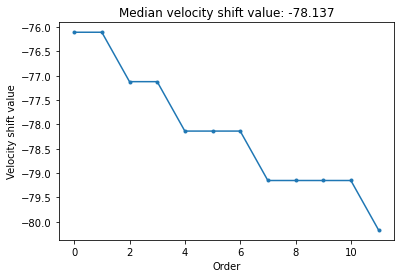

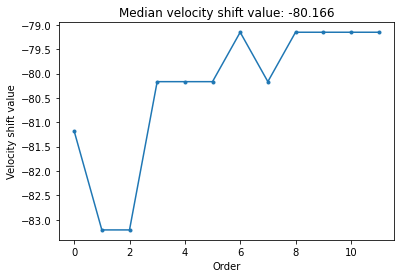

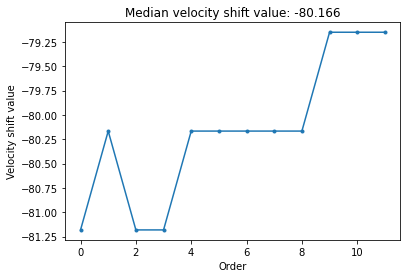

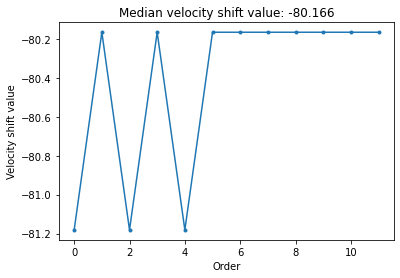

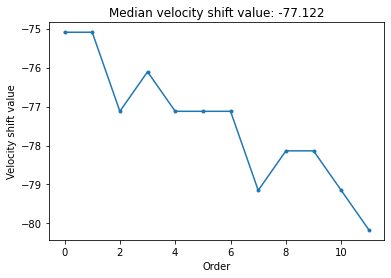

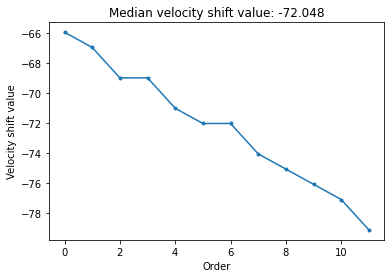

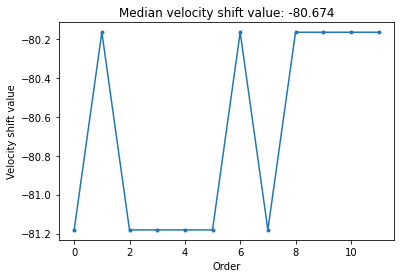

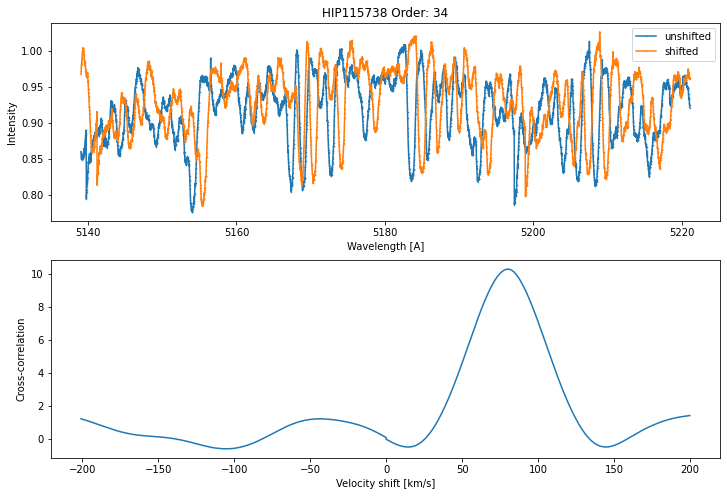

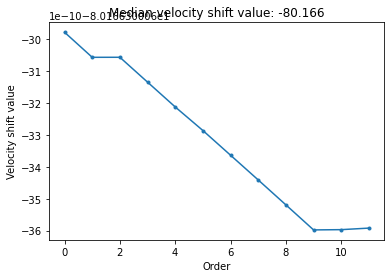

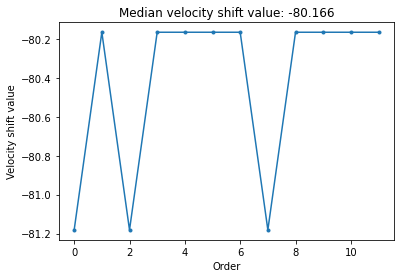

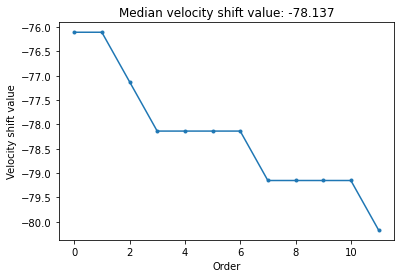

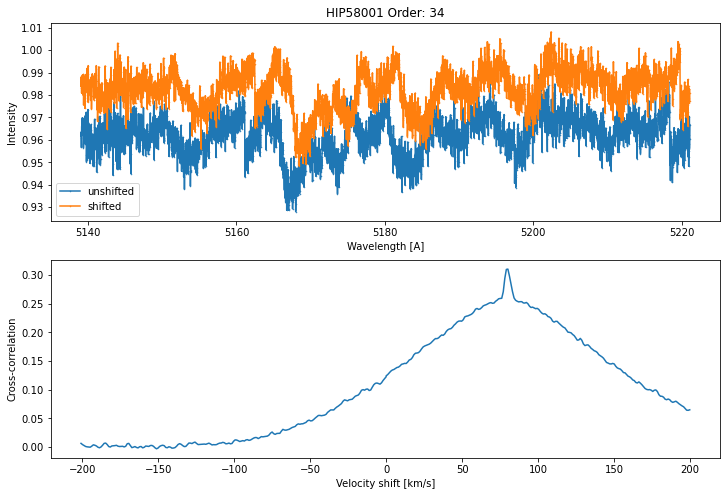

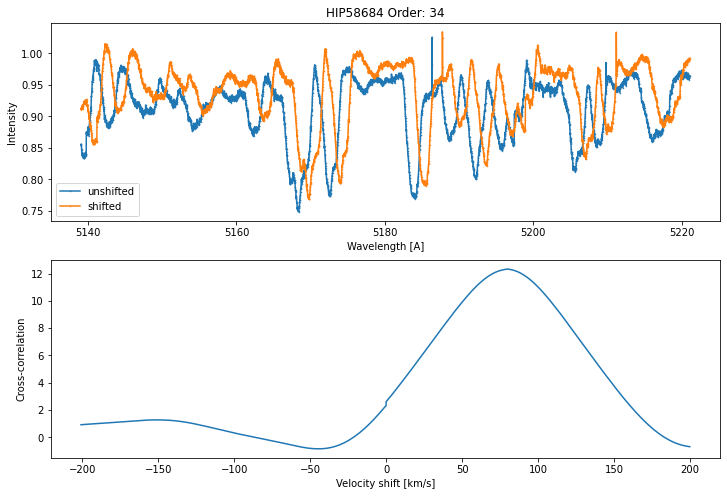

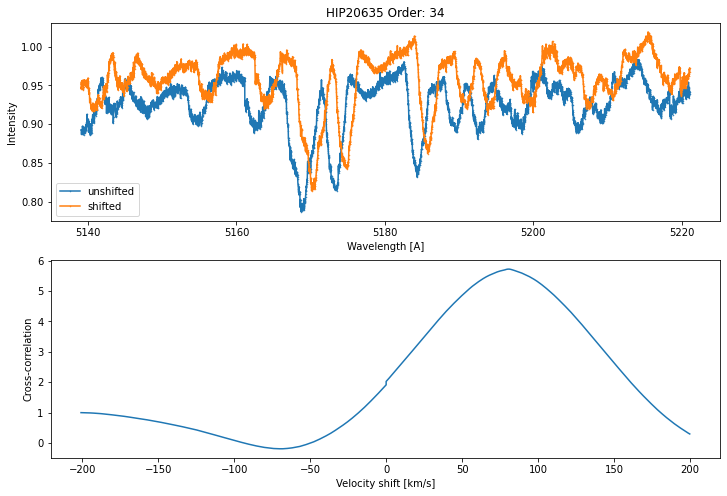

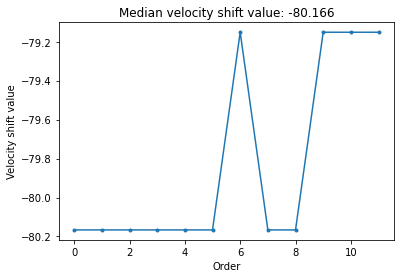

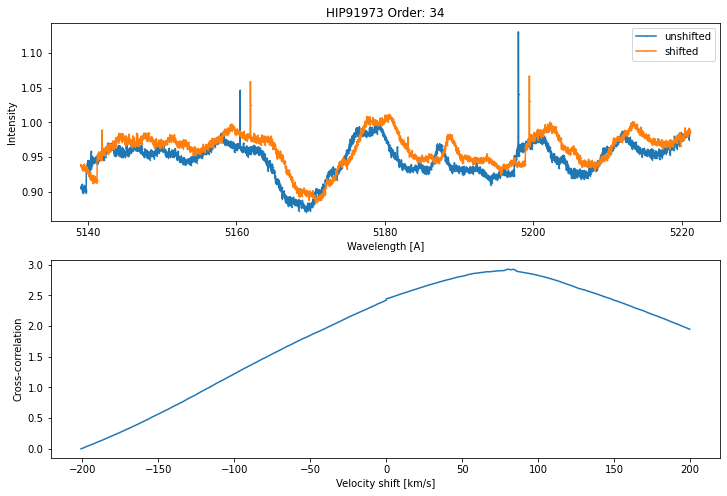

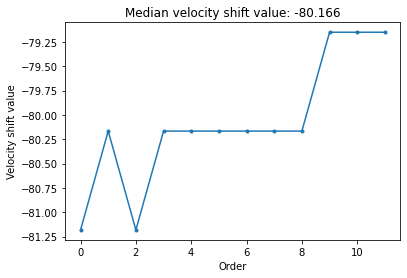

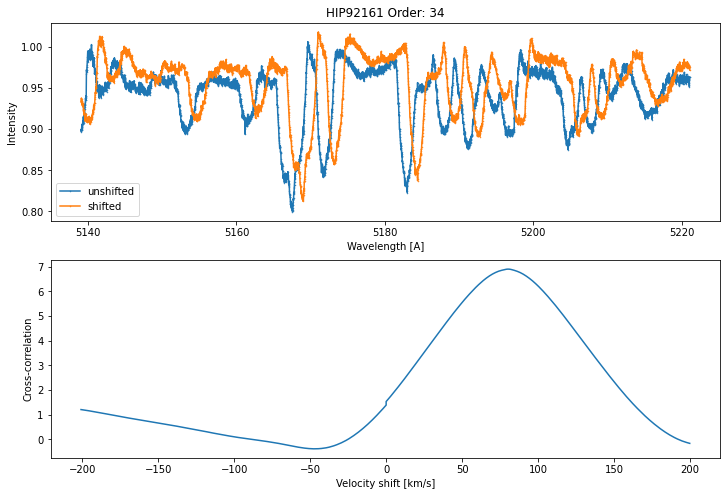

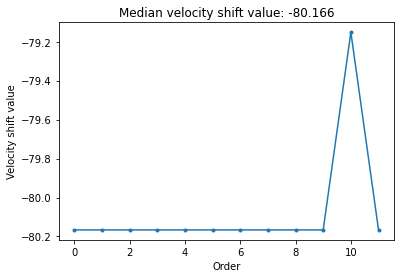

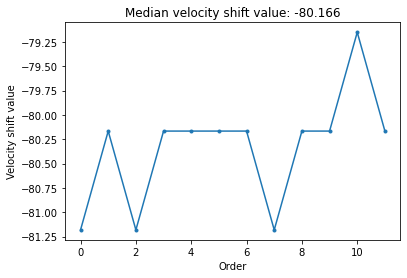

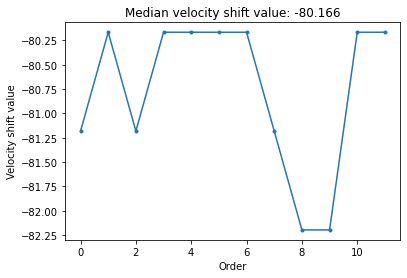

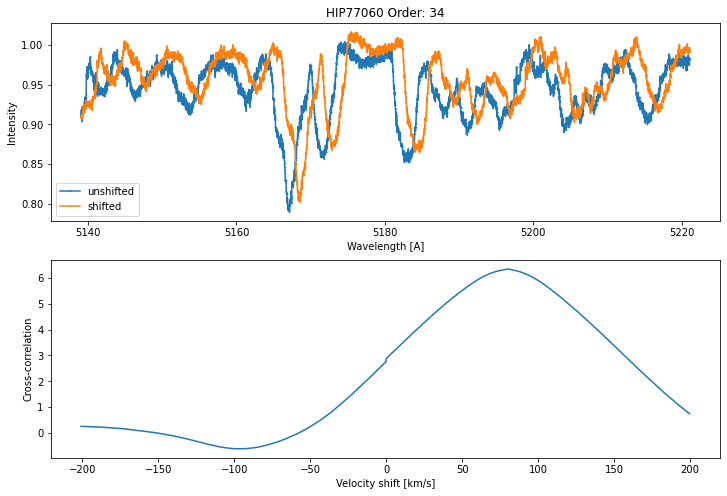

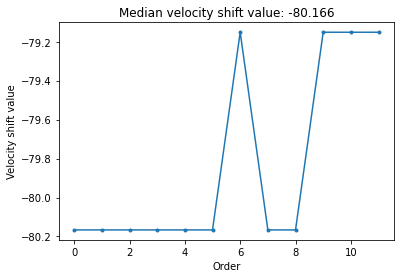

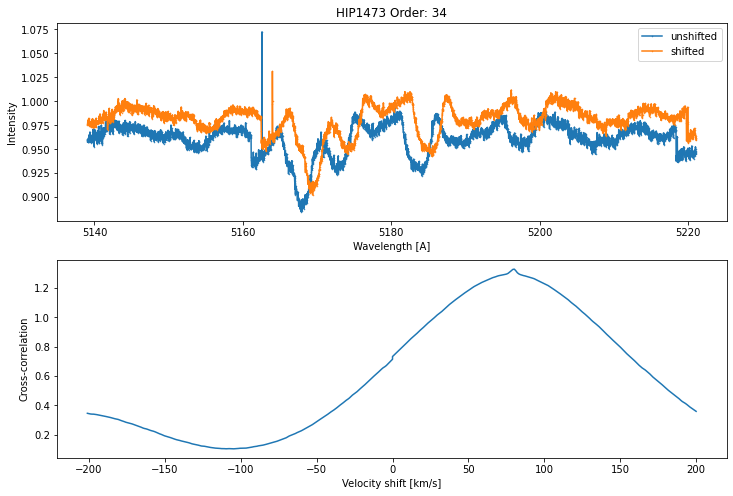

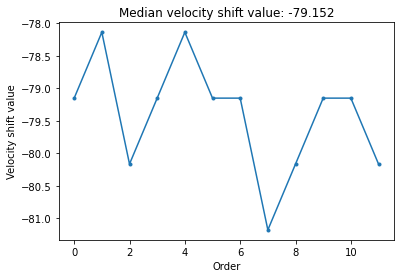

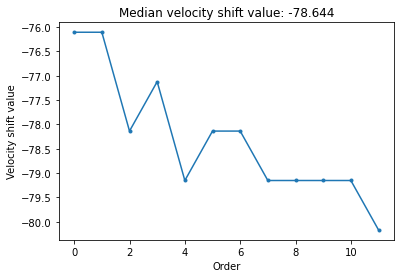

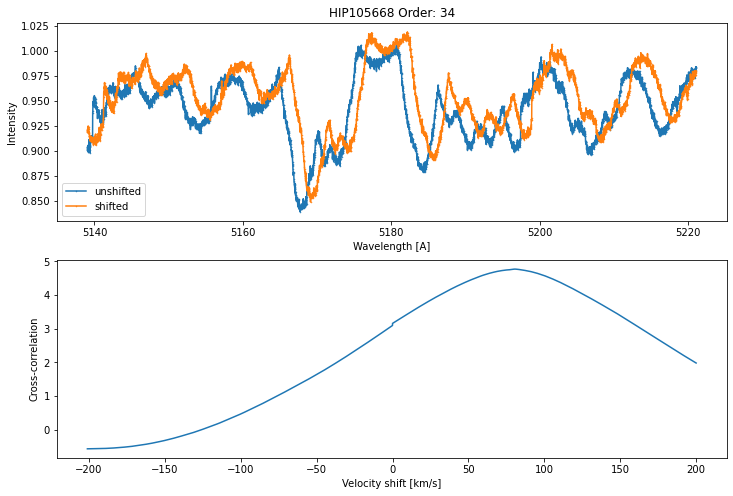

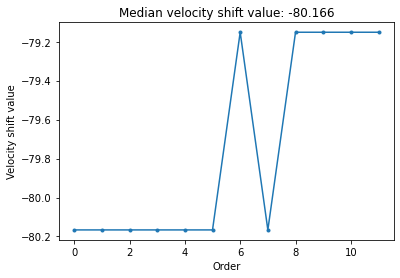

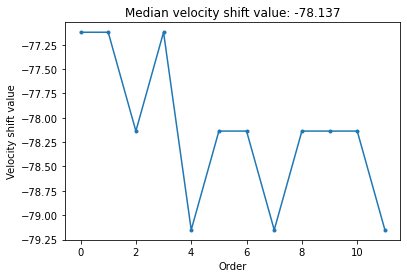

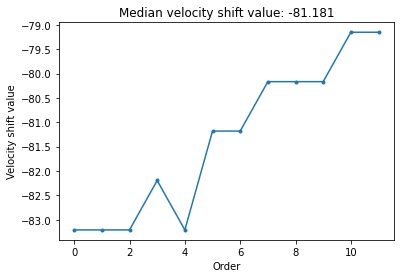

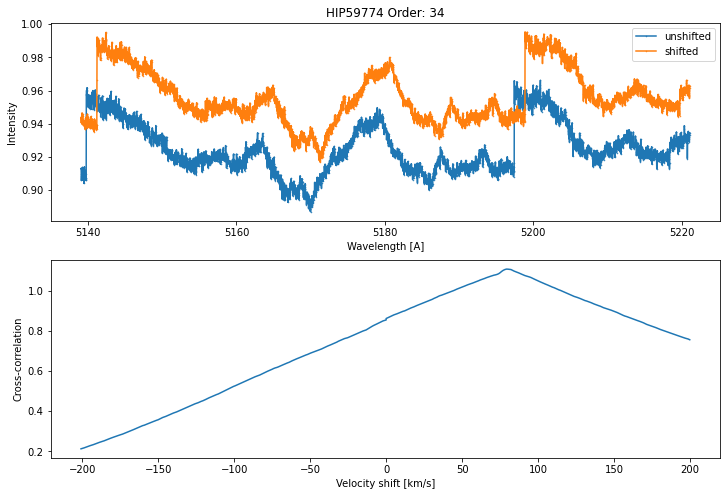

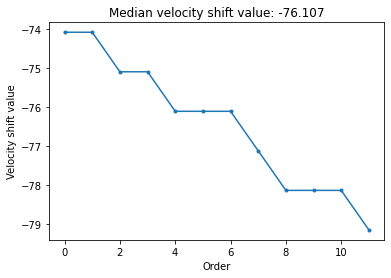

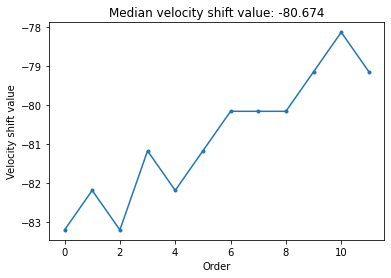

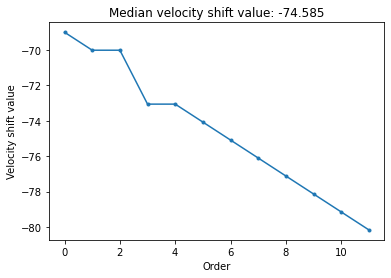

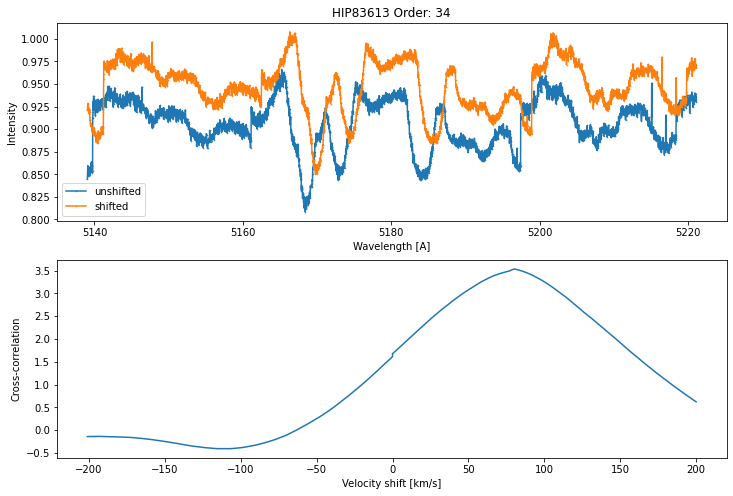

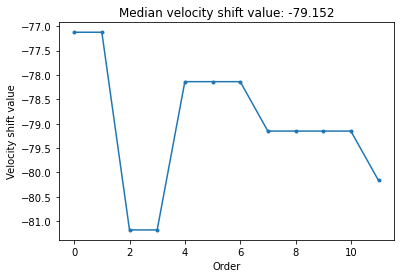

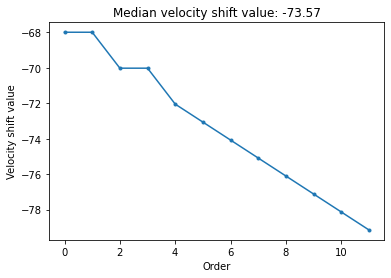

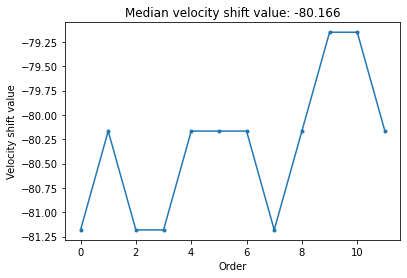

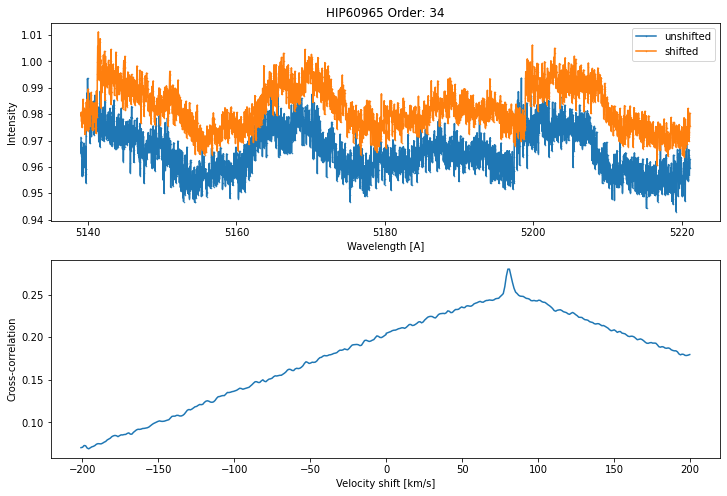

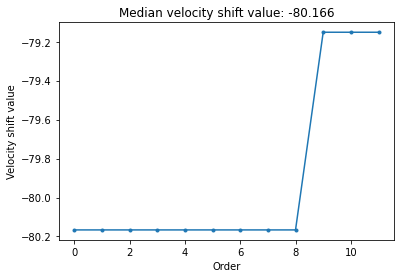

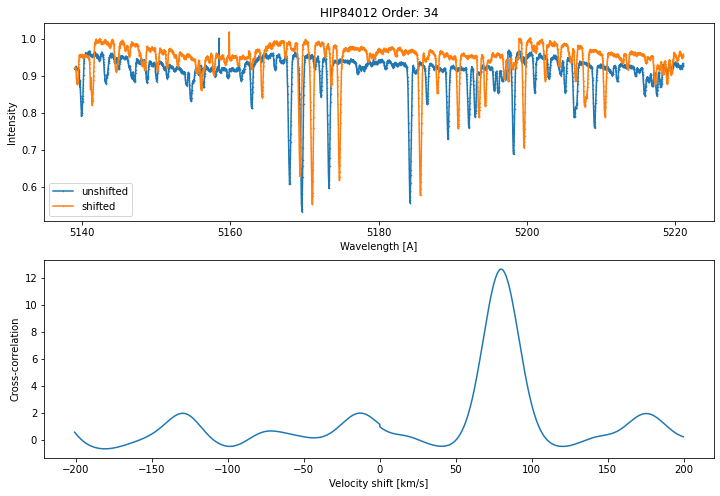

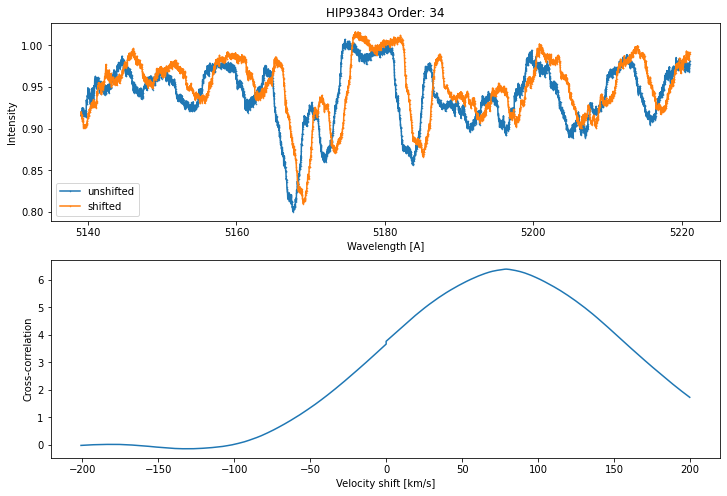

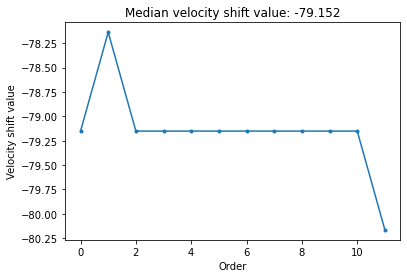

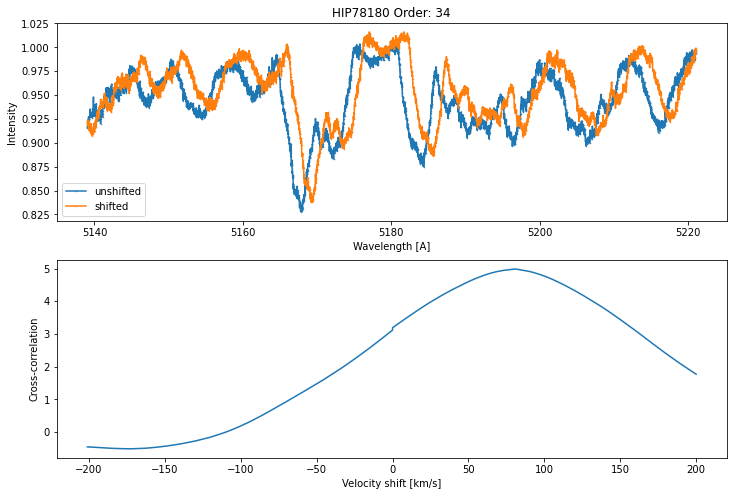

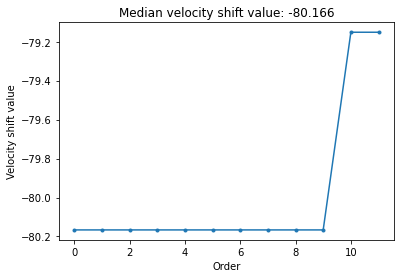

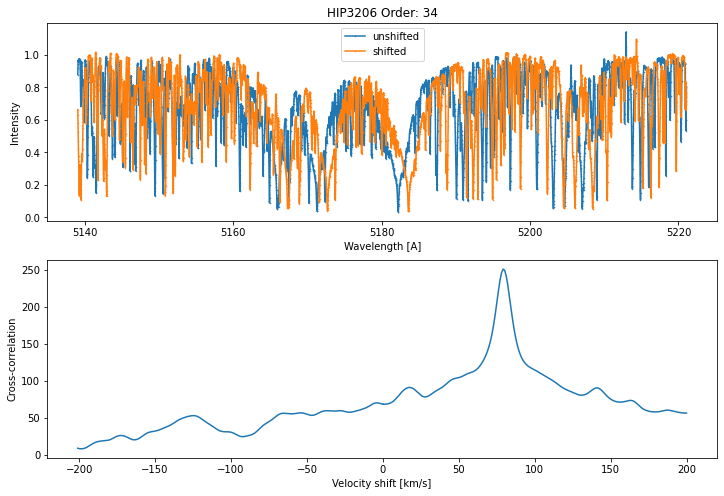

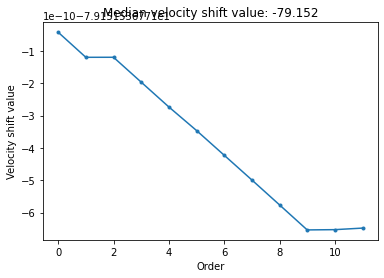

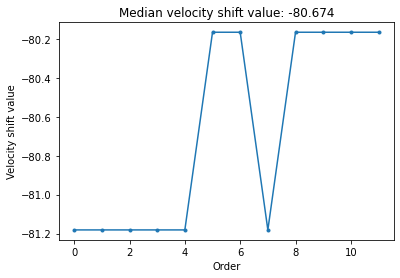

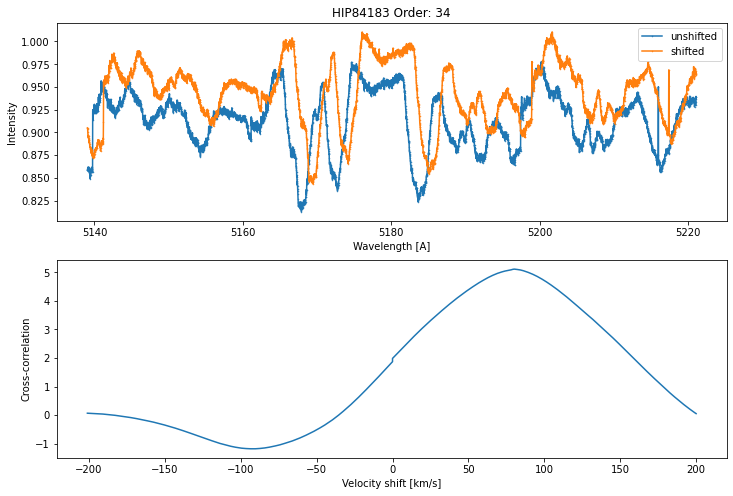

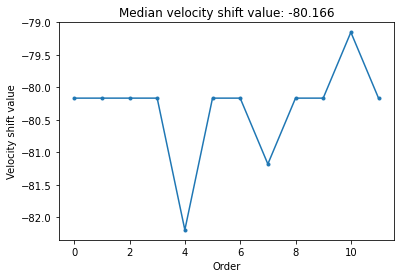

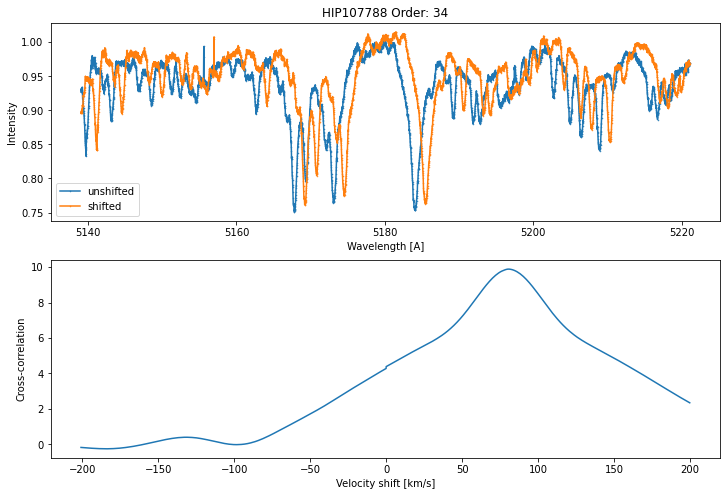

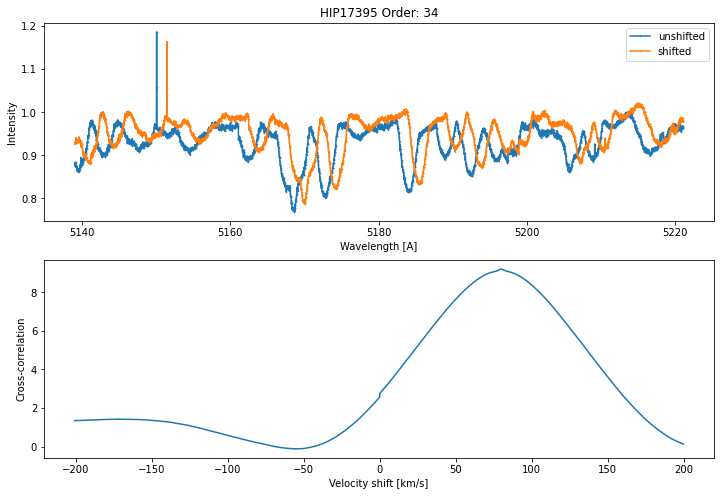

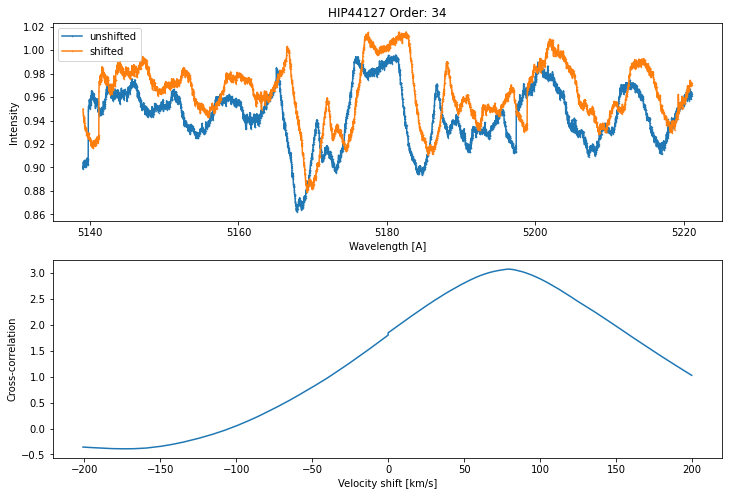

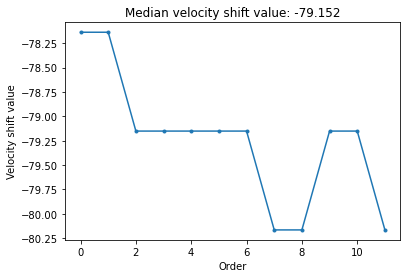

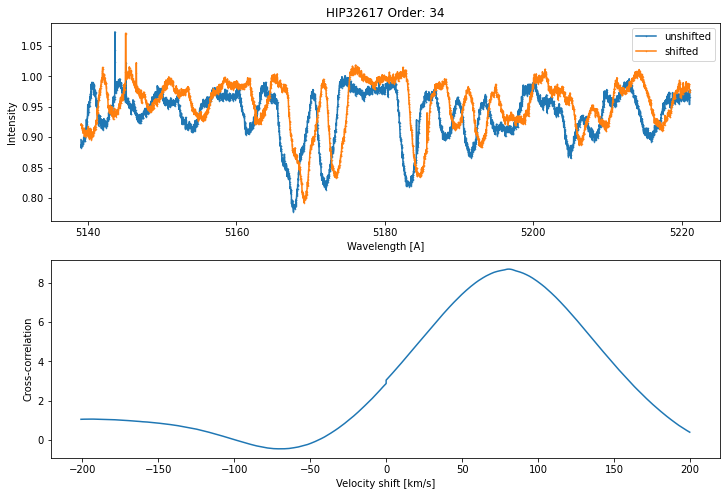

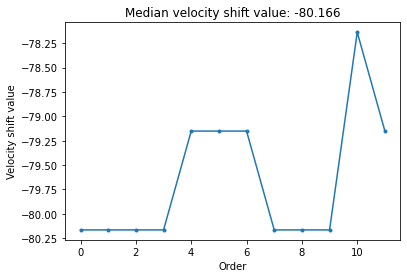

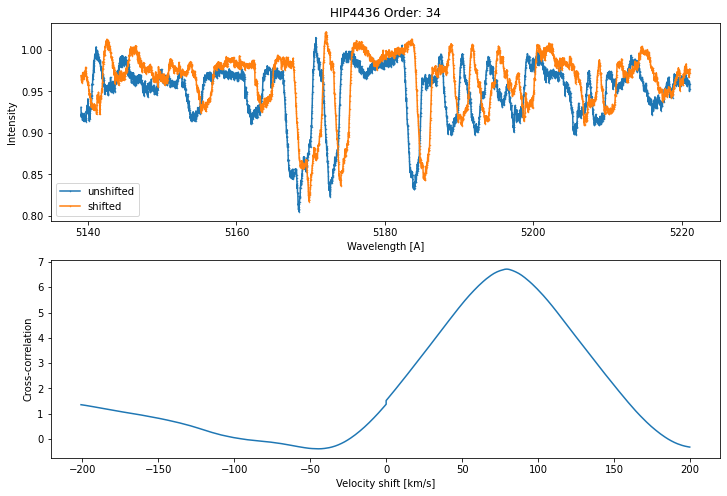

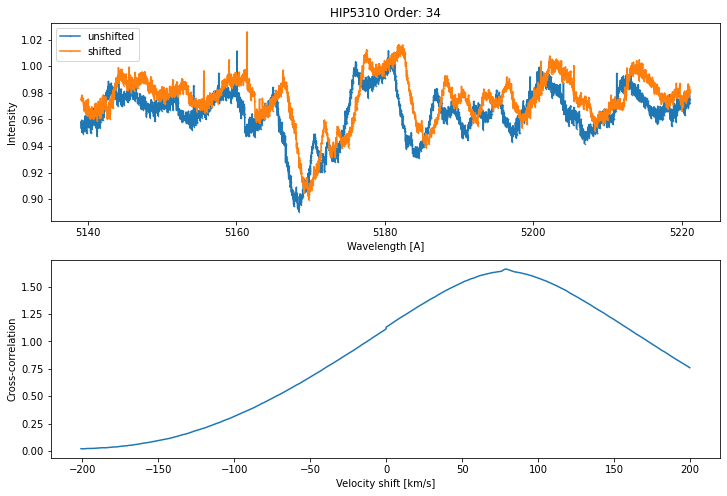

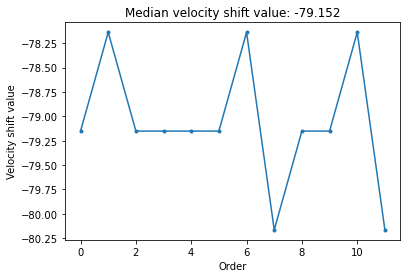

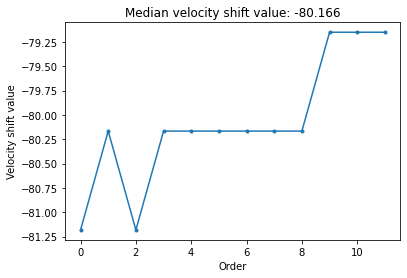

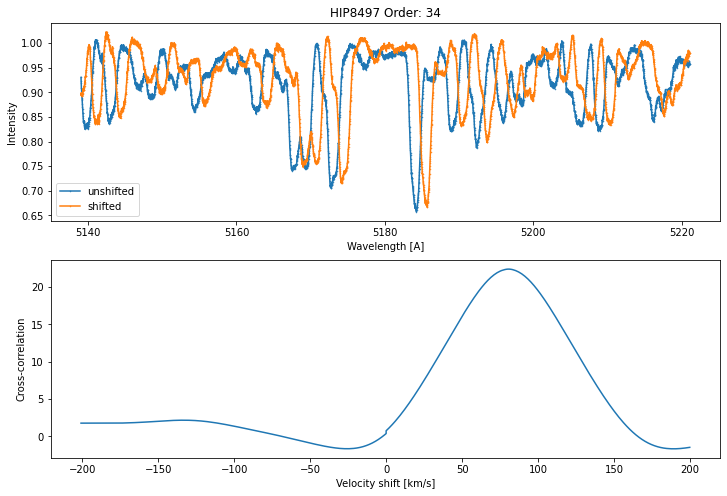

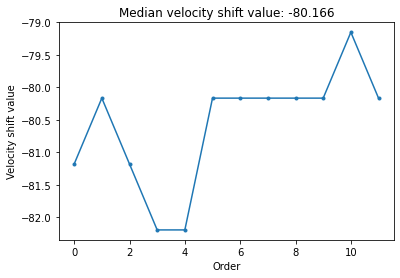

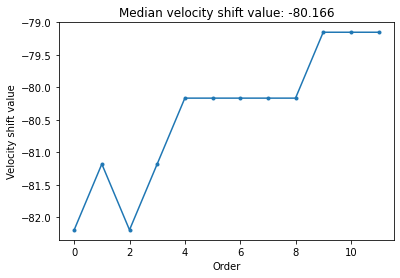

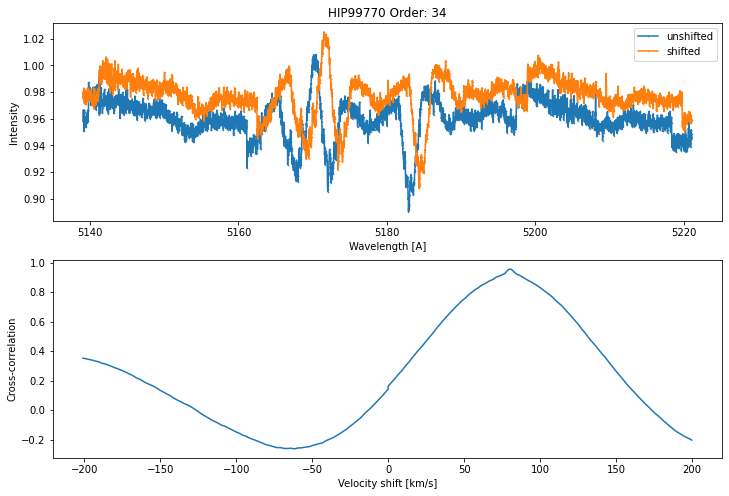

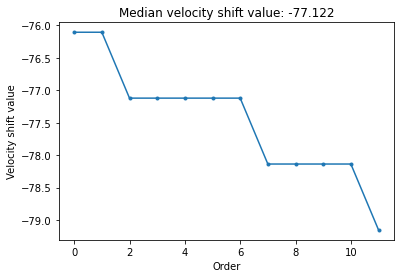

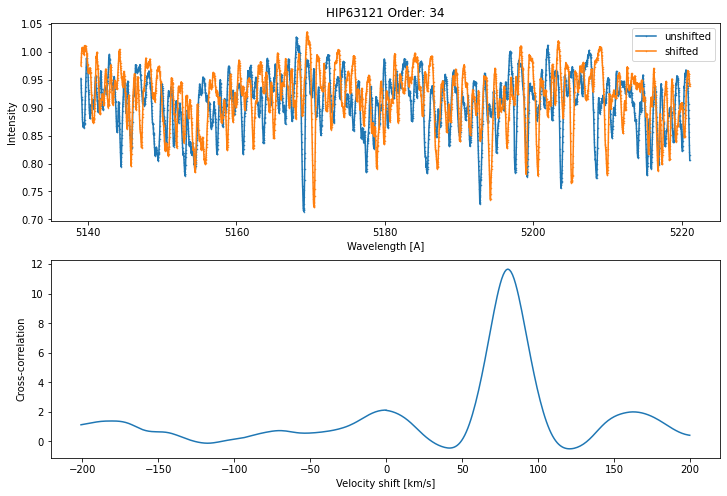

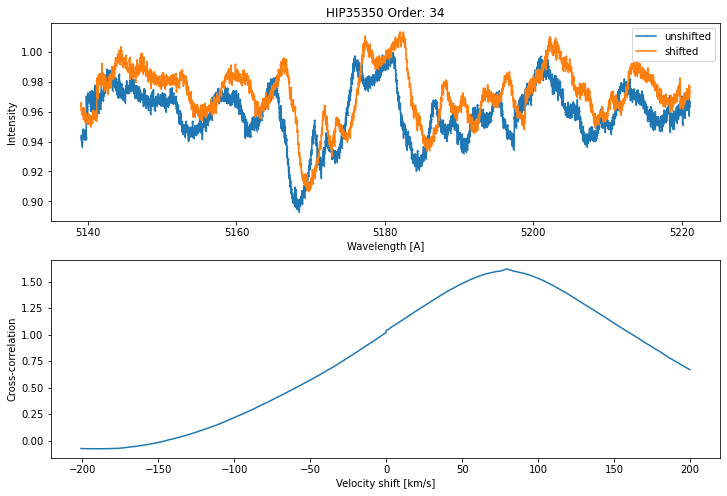

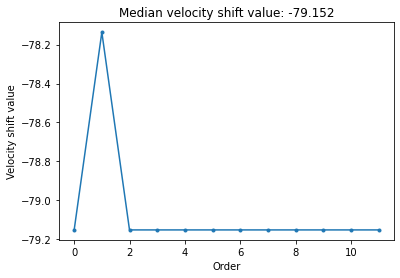

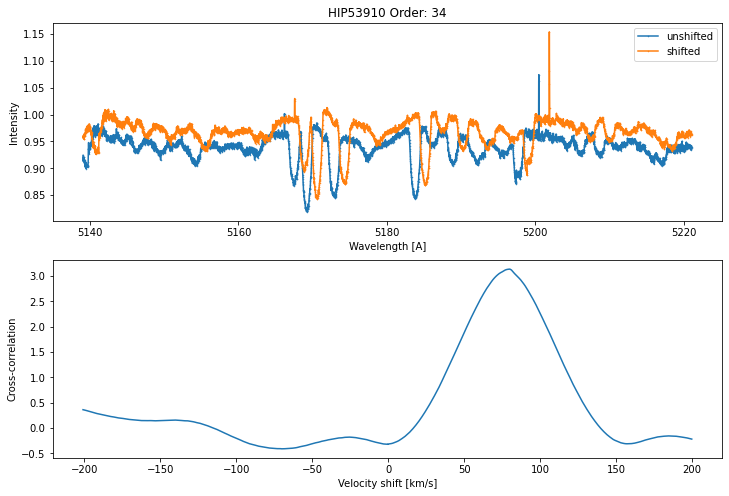

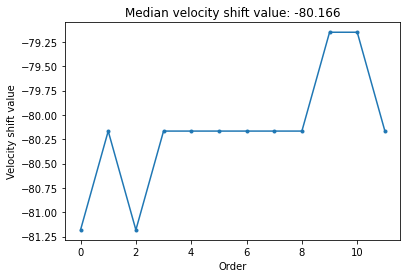

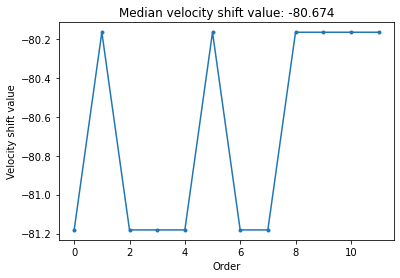

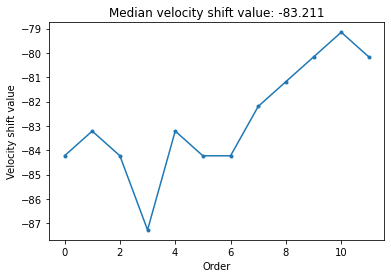

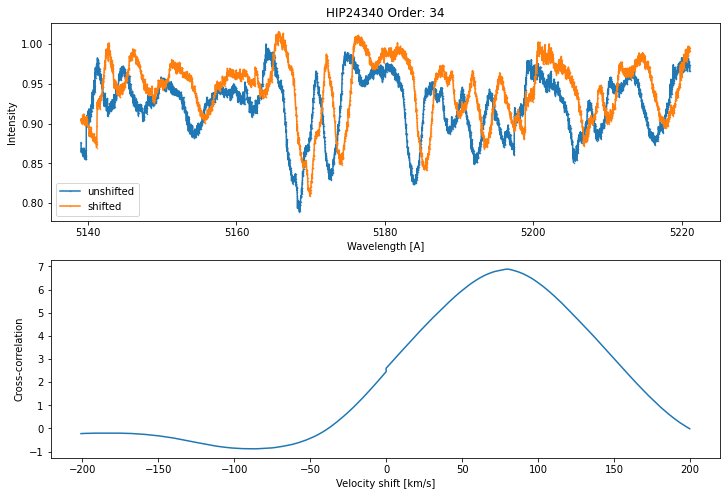

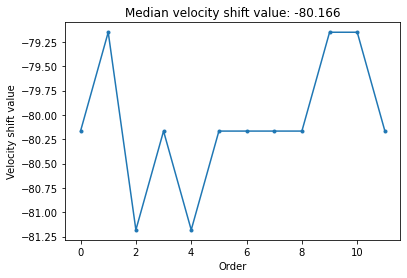

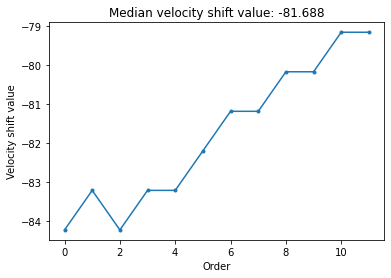

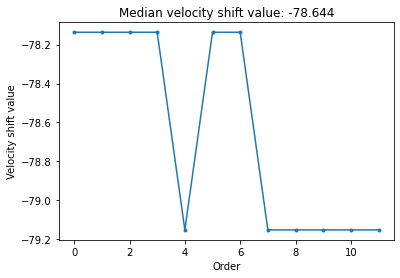

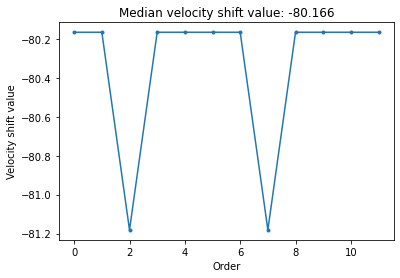

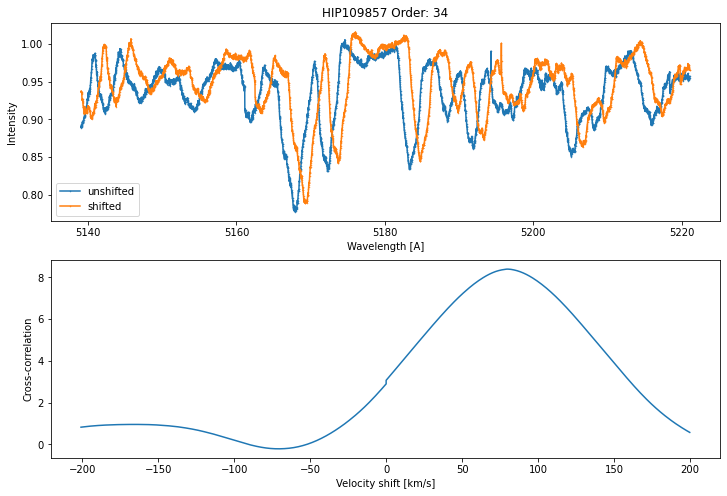

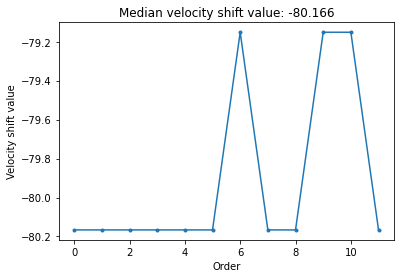

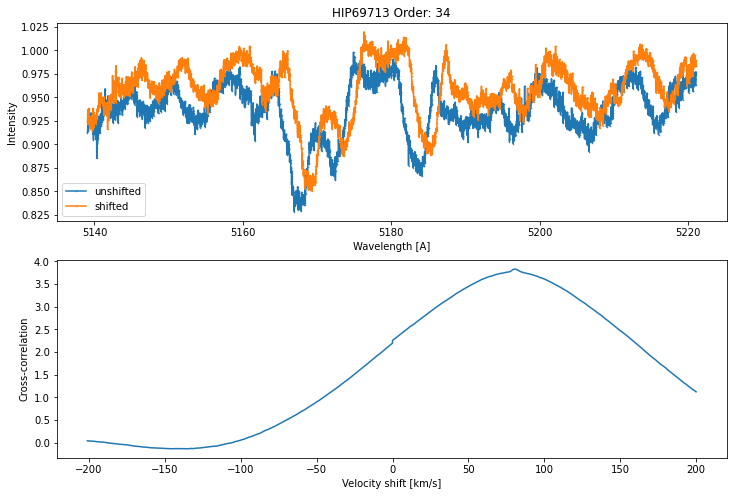

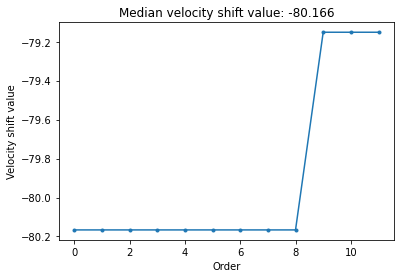

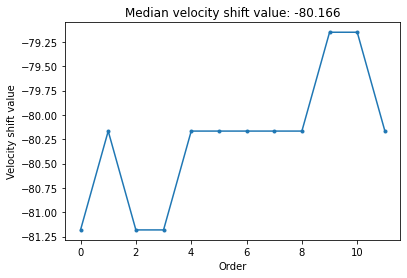

In [30]:
dt = datetime.datetime.now()
print('Timestamp: ' +  str(dt.strftime("%d") + dt.strftime("%b") + dt.strftime("%Y") + '-' + dt.strftime("%X")))

import matplotlib.ticker as plticker
#plt.plot(midpoints[:-2], wl_shift_arr[:-2], 'o')
#plt.plot(wl_shifted, wl_shift_full, '.', ms = 0.1)
# check that this gives the right shifts in wl

star_list = os.listdir('/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRS_all_apf')
all_targets_v_shifts = np.zeros(len(star_list)) * np.nan
mean_max_xcorr =np.zeros(len(star_list)) * np.nan
names = []

i=0
for star in star_list:  
    name = star.split('_')[0] 
    names += [name]
    try:
        NDRU_path = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRU_all_apf/' + name + '_NDRU.fits'
        NDRS_path = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRS_all_apf/' + name + '_NDRS.fits'
        wl_shift_arr, midpoints, wl_shifted, wl_shift_full, wl_unshifted, shifted, unshifted, med_v_shift, max_xcorr_value_arr = calculate_shifts(name, NDRU_path,
                                                                                                                             NDRS_path, 
                                                                                                                             verbosity = 0,
                                                                                                                             make_plots = True)

        all_targets_v_shifts[i] = med_v_shift
        mean_max_xcorr[i] = np.nanmean(max_xcorr_value_arr)
        i += 1
        #if i%100 == 0:
        #    print(i)

        #plt.figure(figsize = [15,5])
        #plt.plot(wl_shifted, shifted, label = 'shifted')
        #plt.plot(wl_unshifted, unshifted, label = 'unshifted')
        #plt.xlim([5550,5560])
        #plt.legend()
        #plt.xlabel('Wavelenght [A]')
        #plt.ylabel('Intensituy')

        print(name + ': ' + str(med_v_shift) + ' km/s')
        print()
        '''
        if med_v_shift < 2:

            for order in np.arange(34,35,1):
                    # find order boundaries
                    apf_order = apf_wave[0].data[order]
                    low_bound = apf_order[1200] # 1200 just to zoom in on plots to see shift better
                    up_bound = apf_order[-1200]

                    # define data for this order
                    idxs_order_shifted = (wl_shifted > low_bound) * (wl_shifted < up_bound) # order 40 for example
                    idxs_order_unshifted = (wl_unshifted > low_bound) * (wl_unshifted < up_bound)
                    flux_U = unshifted[idxs_order_unshifted]
                    flux_S = shifted[idxs_order_shifted]
                    wl_U = wl_unshifted[idxs_order_unshifted]
                    wl_S = wl_shifted[idxs_order_shifted]
                    shifts = wl_shift_full[idxs_order_shifted]

                    fig, ax  = plt.subplots(figsize = [15,5])
                    ax.plot(wl_U, flux_U, color = 'C0',  label = 'unshifted')        
                    ax.plot(wl_S, flux_S, color = 'C1', label = 'shifted')
                    ax.set_xlabel('Wavelength [A]')
                    ax.set_ylabel('Intensity')
                    ax.xaxis.set_major_locator(plticker.MultipleLocator(base=2))
                    ax.xaxis.set_minor_locator(plticker.MultipleLocator(1))
                    ax.legend()

                    #xticks = ax.get_xticks() # get the xtick values for the wavelenght scale
                    #reverse_shifted_xticks = xticks + np.round(xticks * med_v_shift / c * 1000, 2)

                    ax2 = ax.twiny()

                    ax2.plot(wl_S + wl_S * med_v_shift / c * 1000, flux_S, color = 'C3' , ls = None)
                    ax2.xaxis.set_major_locator(plticker.MultipleLocator(base=2))
                    ax2.xaxis.set_minor_locator(plticker.MultipleLocator(1))


                    ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
                    ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
                    ax2.spines['bottom'].set_position(('outward', 36))
                    ax2.set_xlabel('Unshifted wavelenght corresponding to shifted wavelength [A]')
                    plt.title(name + ', order 34')
                '''
    except FileNotFoundError:
        print(name + ':  could not find NDRU file; could not calculate shift.')
        print()
        all_targets_v_shifts[i] = np.nan
        mean_max_xcorr[i] = np.nan
            
            
    
data = {'Star_name': names,
        'Velocity_shift [km/s]': all_targets_v_shifts,
        'X-corr_peak': mean_max_xcorr}

df = pd.DataFrame(data)
#df.to_csv('Velocity_highest_SNR_updated_wls.csv')

In [17]:
from scipy import stats
stats.mode(all_targets_v_shifts)

ModeResult(mode=array([-80.16630006]), count=array([10]))

Text(0.5, 1.0, 'Updated wls')

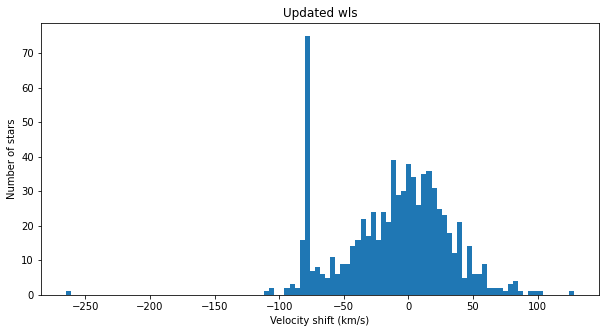

In [31]:
plt.figure(figsize = [10,5])
nan_mask = np.invert(np.isnan(all_targets_v_shifts))
nums, bin_edges =  np.histogram(all_targets_v_shifts[nan_mask], bins = 100)
#print(nums)
#print(bin_edges)
plt.hist(all_targets_v_shifts, bins = 100)
plt.ylabel('Number of stars')
plt.xlabel('Velocity shift (km/s)')
plt.title('Updated wls')
#plt.xlim([-1,10])

In [21]:
nums

array([ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,
        1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  1,
        1,  1,  0,  0,  0

### What cuases the pileup at ~ -80km/s? Is this the same as the pileup at 1km/s using the old wl scale?

In [155]:
slow_stars = [star_list[i].split('_')[0] for i in list(np.where((all_targets_v_shifts < 2) * (all_targets_v_shifts > -2 ))[0])]
len(slow_stars)

46

In [22]:
def get_names(sim_name):
    # get Gaia and 2MASS names 
    result_table = Simbad.query_objectids(sim_name)
    names = result_table.to_pandas()['ID'].to_list()
    gaia_name = [name.decode('utf-8').split(' ')[-1] for name in names if name.decode('utf-8').startswith('Gaia DR2')]
    two_MASS_name = [name.decode('utf-8').split('J')[-1] for name in names if name.decode('utf-8').startswith('2MASS')]
    (gaia_source_id,) = gaia_name
    (id_2MASS,) = two_MASS_name
    return gaia_source_id, id_2MASS

In [23]:
v_shifts_file = pd.read_csv('Velocity_shift_all_targets_updated.csv')
SM_results = pd.read_csv('SM_stellar_properties/all_apf/11Jan2022/specmatch_results_11Jan2022.csv')
gaia_values = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/gaia_values.csv')

star_list = v_shifts_file['Star name']
all_targets_v_shifts = v_shifts_file['Velocity_shift [km/s]']
slow_stars = [star_list[i].split('_')[0] for i in list(np.where(all_targets_v_shifts < 2)[0])]

SNR_arr = np.zeros(len(star_list)) * np.nan
Teff_arr = np.zeros(len(star_list)) * np.nan
R_arr = np.zeros(len(star_list)) * np.nan
gaia_Teff_arr = np.zeros(len(star_list)) * np.nan
gaia_R_arr = np.zeros(len(star_list)) * np.nan
delta_T_arr = np.zeros(len(star_list)) * np.nan
delta_R_arr = np.zeros(len(star_list)) * np.nan
chi_sq_arr = np.zeros(len(star_list)) * np.nan
for i in range(len(star_list)):
    name = star_list[i].split('_')[0]
    results_row = SM_results[SM_results['Simbad_resolvable_name'] == name]
    SNR_arr[i] = results_row['SNR']
    Teff_arr[i] = results_row['iso_Teff']
    R_arr[i] = results_row['iso_radius']
    if Teff_arr[i] == 0: Teff_arr[i] = np.nan
    if R_arr[i] == 0: R_arr[i] = np.nan
    chi_sq_arr[i] = results_row['best_mean_chi_squared']
    
    # get Gaia data to compare
    try:
        gaia_source_id, id_2MASS = get_names(name)
        gaia_row = gaia_values.loc[gaia_values['source_id'] == int(gaia_source_id)] # star has been run so should be here
        gaia_row = gaia_row.median(axis = 0, skipna = True)
        gaia_R_arr[i] = gaia_row['radius_val']
        gaia_Teff_arr[i] = gaia_row['teff_val']
        delta_T_arr[i] = Teff_arr[i] - gaia_Teff_arr[i]
        delta_R_arr[i] = R_arr[i] - gaia_R_arr[i]
    except ValueError:
        gaia_R_arr[i] = np.nan
        gaia_Teff_arr[i] = np.nan
        delta_T_arr[i] = np.nan
        delta_R_arr[i] = np.nan
            #Teff_arr[i] = results_row['iso_Teff']
    

In [ ]:
star_list[all_targets_v_shifts < 2]

No handles with labels found to put in legend.
No handles with labels found to put in legend.


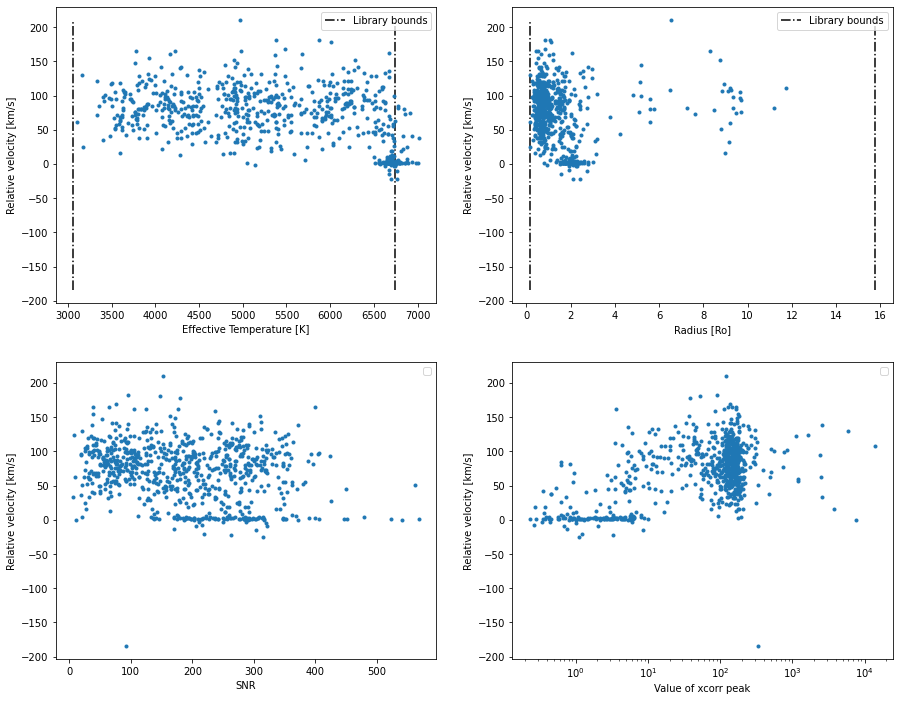

In [27]:

plt.figure(figsize = [15,12])
plt.subplot(221)
plt.plot(Teff_arr, all_targets_v_shifts, '.')
plt.vlines([3056, 6738], ymin = np.nanmin(all_targets_v_shifts), ymax = np.nanmax(all_targets_v_shifts), ls = '-.',  label = 'Library bounds')
plt.xlabel('Effective Temperature [K]')
plt.ylabel('Relative velocity [km/s]')
plt.legend()

plt.subplot(222)
plt.plot(R_arr, all_targets_v_shifts, '.')
plt.vlines([0.168, 15.781], ymin = np.nanmin(all_targets_v_shifts), ymax = np.nanmax(all_targets_v_shifts), ls = '-.',  label = 'Library bounds')
plt.xlabel('Radius [Ro]')
plt.ylabel('Relative velocity [km/s]')
plt.legend()

plt.subplot(223)
plt.plot(SNR_arr, all_targets_v_shifts, '.')
plt.xlabel('SNR')
plt.ylabel('Relative velocity [km/s]')
plt.legend()

plt.subplot(224)
plt.plot(mean_max_xcorr, all_targets_v_shifts, '.')
plt.xlabel('Value of xcorr peak')
plt.ylabel('Relative velocity [km/s]')
plt.xscale('log')
plt.legend()

773

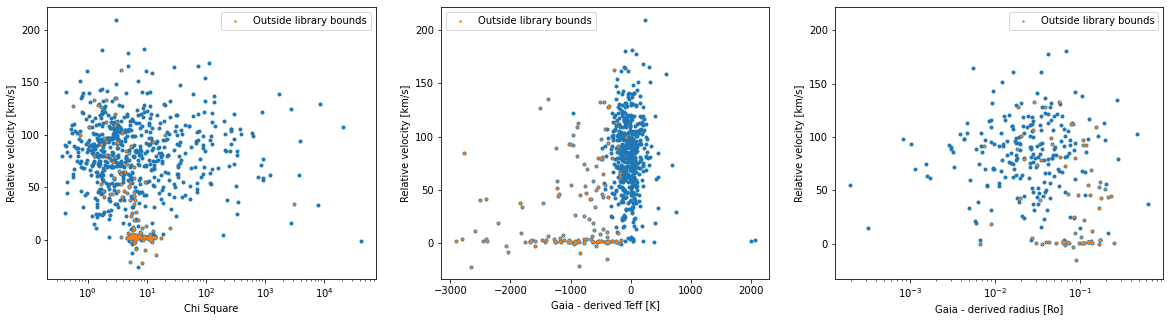

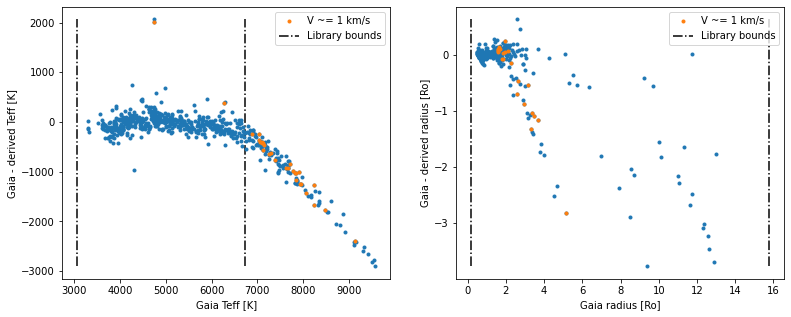

In [32]:
# do the stars that are given a ~1 km/s velocity shift by SM produce poor stellar property results 
# (indicating they are shifted improprly)

slow_star_mask = (all_targets_v_shifts < 2) * (all_targets_v_shifts > 0)
outside_gaia_T_bounds = (gaia_Teff_arr > 6738) | (gaia_Teff_arr < 3056)
outside_gaia_R_bounds = (gaia_R_arr > 15.781) | (gaia_R_arr < 0.168)

plt.figure(figsize = [20,5])
plt.subplot(131)
plt.plot(chi_sq_arr, all_targets_v_shifts, '.')
plt.plot(chi_sq_arr[outside_gaia_T_bounds | outside_gaia_R_bounds], all_targets_v_shifts[outside_gaia_T_bounds | outside_gaia_R_bounds], '.', ms = 3, label = 'Outside library bounds')
plt.xlabel('Chi Square')
plt.ylabel('Relative velocity [km/s]')
plt.xscale('log')
plt.legend()

plt.subplot(132)
plt.plot(delta_T_arr, all_targets_v_shifts, '.')
plt.plot(delta_T_arr[outside_gaia_T_bounds | outside_gaia_R_bounds], all_targets_v_shifts[outside_gaia_T_bounds | outside_gaia_R_bounds], '.', ms = 3, label = 'Outside library bounds')
plt.xlabel('Gaia - derived Teff [K]')
plt.ylabel('Relative velocity [km/s]')
#plt.xscale('log')
plt.legend()

plt.subplot(133)
plt.plot(delta_R_arr, all_targets_v_shifts, '.')
plt.plot(delta_R_arr[outside_gaia_T_bounds | outside_gaia_R_bounds], all_targets_v_shifts[outside_gaia_T_bounds | outside_gaia_R_bounds], '.', ms = 3, label = 'Outside library bounds')
plt.xlabel('Gaia - derived radius [Ro]')
plt.ylabel('Relative velocity [km/s]')
plt.xscale('log')
plt.legend()


plt.figure(figsize = [20,5])
plt.subplot(131)
plt.plot(gaia_Teff_arr, delta_T_arr, '.')
plt.plot(gaia_Teff_arr[slow_star_mask], delta_T_arr[slow_star_mask], '.', label = 'V ~= 1 km/s')
plt.vlines([3056, 6738], ymin = np.nanmin(delta_T_arr), ymax = np.nanmax(delta_T_arr), ls = '-.',  label = 'Library bounds')
plt.xlabel('Gaia Teff [K]')
plt.ylabel('Gaia - derived Teff [K]')
plt.legend()

plt.subplot(132)
plt.plot(gaia_R_arr, delta_R_arr, '.')
plt.plot(gaia_R_arr[slow_star_mask], delta_R_arr[slow_star_mask], '.', label = 'V ~= 1 km/s')
plt.vlines([0.168, 15.781], ymin = np.nanmin(delta_R_arr), ymax = np.nanmax(delta_R_arr), ls = '-.',  label = 'Library bounds')
plt.xlabel('Gaia radius [Ro]')
plt.ylabel('Gaia - derived radius [Ro]')
plt.legend()

In [125]:
delta_T

-48.24300000000039